In [11]:
import os
# os.getcwd()
# os.path.exists('../../../../venv_citynet3/Lib/site-packages/')
# os.path.exists('C:/mallet/bin/mallet.bat')

True

In [ ]:
# import sys
# sys.path.append('../../../../venv_citynet3/Lib/site-packages/')

In [26]:
import os
import pickle

# gensim LDA
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel

# Visualise
import warnings
# warnings.filterwarnings('ignore')
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Vectorize Words (dictionary & corpus)

In [6]:
def vectorize(lemmatized_text, filter_extremes=True, MIN_DF = 5, MAX_DF = 1):
    """
    -->
        function that vectorizes preprocessed (lemmatized) text.

        Parameters:
        -----------
            lemmatized_text: list, str -> contains the key words to be matched
            MIN_DF: int (default = 1) -> minimum document frequency (only keep the words occuring in at least one document)
            MAX_DF: int (default = 0.6) -> maximum document frequency (word has to occur in less than 60% of the documents)

    """
    
    # Get Vocabulary
    dictionary = Dictionary(lemmatized_text)
    
    if filter_extremes:
        dictionary.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)
    
    corpus = [dictionary.doc2bow(text) for text in lemmatized_text]
    
    return(dictionary, corpus)

# Train LDA Model

In [8]:
PATH_TO_MALLET = r'C:/mallet/bin/mallet.bat'

def train_model(lemmatized_text, dictionary=[], corpus=[], MIN_DF = 2, MAX_DF = 1, N_TOPICS = 10, N_ITERATIONS = 1000):
    """
    -->
        function that trains model.

        Parameters:
        -----------
            lemmatized_text: list, str -> contains the key words to be matched (created with the lemmatization function)
            dictionary: gensim.corpora.dictionary.Dictionary -> output from vectorization function
            corpus: list ([dictionary.doc2bow(text)...) -> output from vectorization function
            MIN_DF: int (default = 1) -> minimum document frequency
            MAX_DF: int (default = 0.6) -> maximum document frequency
            N_TOPICS: int (default = 10) -> Topics to detect
            N_ITERATIONS: int (default = 1000) -> 1000 often enough

    """

    # Call vectorization function if either dictionary or corpus is missing as parameter
#     if vectorize and not type(dictionary) == gensim.corpora.dictionary.Dictionary or not corpus:
#         dictionary, corpus = vectorize(lemmatized_text, MIN_DF, MAX_DF)
    
    lda_model = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                alpha=auto
                optimize_interval=10,
                iterations=N_ITERATIONS)
    
    coherence_score = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v').get_coherence()
    
    return(lda_model, coherence_score, dictionary, corpus)

# Single Paragraph as a document

In [30]:
import pickle
import os 
from tqdm.notebook import tqdm
import re
import spacy

# nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_lg")
nlp.max_length = 1500000
nlp.disable_pipes('ner', 'parser')

['ner', 'parser']

In [205]:
%%time

FILE_PATH = "../../../../data/enwiki_city_pairs/biggest_cities_5/paris_london.txt"
POS = ["VERB", "NOUN", "ADJ"]

with open(FILE_PATH, 'r', encoding='utf-16') as f:
    city_pair_text_list = [x.strip().lower() for x in f.read().replace('"', "'").replace('“', "'").replace('”', "'").split('\n') if len(x) and 'title=' not in x]

sample_of_paragraphs = city_pair_text_list
# for x in city_pair_text_list[:50]:
#     print(x)
#     print()

# nr_of_chunks = len(city_pair_text_list)//1000 + 1
# chunk_size = (len(city_pair_text_list)-1)//nr_of_chunks
# chunked_text = [' '.join(city_pair_text_list[offs:offs+chunk_size]) for offs in range(0, len(city_pair_text_list), chunk_size)]

chunked_text = sample_of_paragraphs
processed_text = [text for text in tqdm(nlp.pipe(chunked_text, n_process=2, batch_size=1, disable=["ner", "parser"]), total=len(chunked_text))]
lemmatized_text = [[word.lemma_ for word in text if word.pos_ in POS and not word.is_punct and not word.is_stop] for text in processed_text]
# [word.lemma_ for word in text if word.pos_ in ["VERB"] and not word.is_punct and not word.is_stop]
# # [word.lemma_ for word in processed_text if word.pos_ in ["VERB"] and not word.is_punct and not word.is_stop]
regexed_text = [[re.sub(r'\W+', '', word) for word in text] for text in lemmatized_text]
# flattened_words = [item for sublist in regexed_text for item in sublist]

  0%|          | 0/21193 [00:00<?, ?it/s]

CPU times: total: 56.2 s
Wall time: 3min 28s


In [207]:
DIRECTORY = "../../../../data/enwiki_city_pairs_lemmatised/"
with open(os.path.join(DIRECTORY, 'parislondon.txt'), 'wb') as fp:
        pickle.dump(regexed_text, fp)

In [211]:
with open(os.path.join(DIRECTORY, 'parislondon.txt'), 'rb') as fp:
        wordlists = pickle.load(fp)

In [215]:
# for x in wordlists[:500]:
#     print(len(x))

In [128]:
len(city_pair_text_list), len(regexed_text)

(3264, 3264)

# Vectorize

In [216]:
dictionary, corpus = vectorize(wordlists, filter_extremes=True, MIN_DF=0.05, MAX_DF=0.9)

In [217]:
%%time
N_TOPICS = 10
lda_model, coherence_score, dictionary, corpus = train_model(wordlists, dictionary, corpus, N_TOPICS=N_TOPICS)

CPU times: total: 4.41 s
Wall time: 1min 27s


In [218]:
coherence_score

0.6225216256400748

# Visualisation

In [219]:
warnings.filterwarnings('ignore')
pyLDAvis.enable_notebook()

lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model) # my_models[0]['lda_model__2']['model']
gensimvis.prepare(lda_conv, corpus, dictionary)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.115751  0.118593       1        1  14.888620
0     -0.007064  0.093066       2        1  14.046212
2     -0.165449  0.057257       3        1  10.447328
3     -0.016079  0.038787       4        1  10.120699
7     -0.081199 -0.210056       5        1   9.756601
5     -0.118833  0.258895       6        1   9.648022
4     -0.222171 -0.190734       7        1   8.836422
9      0.136567 -0.057000       8        1   8.640431
8      0.104886 -0.025133       9        1   7.788923
1      0.253592 -0.083675      10        1   5.826741, topic_info=               Term         Freq        Total Category  logprob  loglift
355             art  6702.000000  6702.000000  Default  30.0000  30.0000
978           study  4772.000000  4772.000000  Default  29.0000  29.0000
1701          opera  2602.000000  2602.000000  Default  28.0000  28.0000
711      exhibition  2624.000000  2624.000000  Default  27.0000  27.0000
633            film  2351.000000  2351.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
225   international   218.125139  2456.854098  Topic10  -5.3477   0.4211
85            serve   205.480203  1286.795166  Topic10  -5.4074   1.0082
429            high   200.211480  1008.635227  Topic10  -5.4334   1.2257
345           start   202.318969  1258.643178  Topic10  -5.4229   1.0148
581          travel   200.211480  2284.099115  Topic10  -5.4334   0.4084

[1010 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4398      3  0.980093   150th
1490      4  0.278812    18th
1490      8  0.726072    18th
192       2  0.014213    19th
192       3  0.017766    19th
...     ...       ...     ...
2775      5  0.961954  zephyr
2107      2  0.008805   école
2107      3  0.136472   école
2107      6  0.854048   école
998       4  0.946315  ʻabdul

[2371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 4, 8, 6, 5, 10, 9, 2])

# Word Topic Distribution

In [174]:
MAX_WORDS = 8

for i in range(N_TOPICS):
    topic_words = lda_model.show_topic(i, topn=MAX_WORDS)
    print(i+1, [(x[0], round(x[1], 3)) for x in topic_words])

1 [('study', 0.04), ('bear', 0.023), ('work', 0.021), ('school', 0.018), ('year', 0.018), ('family', 0.011), ('move', 0.011), ('graduate', 0.009)]
2 [('art', 0.047), ('work', 0.036), ('exhibition', 0.032), ('exhibit', 0.019), ('painting', 0.015), ('gallery', 0.015), ('museum', 0.013), ('design', 0.012)]
3 [('fashion', 0.075), ('model', 0.051), ('week', 0.032), ('walk', 0.017), ('show', 0.016), ('designer', 0.014), ('work', 0.014), ('magazine', 0.014)]
4 [('french', 0.013), ('government', 0.007), ('political', 0.007), ('war', 0.007), ('army', 0.006), ('minister', 0.006), ('send', 0.006), ('appoint', 0.006)]
5 [('win', 0.027), ('club', 0.024), ('team', 0.023), ('season', 0.021), ('final', 0.018), ('goal', 0.015), ('play', 0.015), ('game', 0.013)]
6 [('return', 0.015), ('year', 0.014), ('time', 0.011), ('leave', 0.011), ('meet', 0.009), ('work', 0.009), ('travel', 0.008), ('visit', 0.008)]
7 [('opera', 0.078), ('perform', 0.025), ('role', 0.023), ('sing', 0.018), ('debut', 0.016), ('festi

# Document Topic Distribution

In [221]:
import pandas as pd

transformed_docs = lda_model.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i+1) for i in range(N_TOPICS)])
# topic_distributions['city_pairs'] = city_pairs
# topic_distributions.set_index("city_pairs", inplace=True)
topic_distributions

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.025452,0.000957,0.002092,0.091281,0.669746,0.002175,0.203053,0.001717,0.001783,0.001745
1,0.001603,0.326737,0.001056,0.001096,0.000715,0.012348,0.001290,0.023367,0.000900,0.630888
2,0.002266,0.000683,0.001493,0.001549,0.016912,0.065158,0.892296,0.001225,0.017174,0.001245
3,0.965943,0.001962,0.004289,0.004451,0.002902,0.004460,0.005237,0.003521,0.003656,0.003578
4,0.007965,0.002400,0.005249,0.005446,0.003552,0.005457,0.341830,0.004308,0.004474,0.619318
...,...,...,...,...,...,...,...,...,...,...
21188,0.206626,0.001725,0.003772,0.003914,0.002553,0.164643,0.607308,0.003096,0.003216,0.003147
21189,0.002302,0.000694,0.001517,0.130840,0.001027,0.001577,0.001852,0.728366,0.001293,0.130531
21190,0.049338,0.014868,0.032510,0.380000,0.021998,0.380073,0.039695,0.026685,0.027712,0.027121
21191,0.003485,0.001050,0.002296,0.149125,0.026011,0.002388,0.663145,0.001885,0.001957,0.148658


In [228]:
topic_distributions.idxmax(axis=1).value_counts()

topic_1     2901
topic_3     2784
topic_7     2577
topic_6     2463
topic_5     2262
topic_8     2118
topic_9     1876
topic_4     1661
topic_10    1372
topic_2     1179
dtype: int64

# Topic Coverage Distribution

In [229]:
distribution = topic_distributions.mean().sort_values(ascending=False)
sorted_distribution = distribution.sort_index()
distribution

topic_1     0.139062
topic_7     0.125443
topic_3     0.119775
topic_6     0.113066
topic_5     0.095946
topic_8     0.095751
topic_9     0.091200
topic_4     0.089326
topic_10    0.073989
topic_2     0.056442
dtype: float64

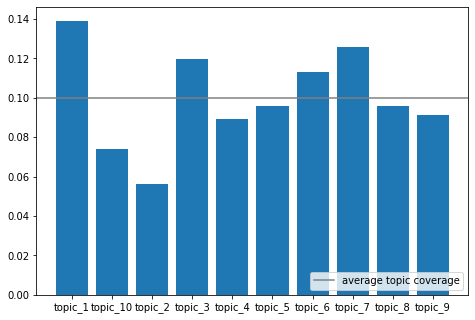

In [230]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = sorted_distribution.index
students = list(sorted_distribution)
ax.bar(langs,students)
average_topic_coverage = sum(sorted_distribution)/len(sorted_distribution)

plt.axhline(average_topic_coverage, color='grey', ls='-', label='average topic coverage')
plt.legend(loc='lower right')
plt.show()

# Save Model

In [126]:
keyname= 'all3264paragraphsofparismilan10topics0_05and0_9coherence0_61'
model_path = f'../../../../data/lda_models/{keyname}.model'
lda_model.save(model_path)

# Load Model

In [90]:
if os.path.exists(model_path):
    model = gensim.models.LdaModel.load(model_path)

In [80]:
# MAX_WORDS = 8
# N_TOPICS = 10

# for i in range(N_TOPICS):
#     topic_words = model.show_topic(i, topn=MAX_WORDS)
#     print(i, [(x[0], round(x[1], 3)) for x in topic_words])

In [231]:
# 1. Train LDA model on all paragraphs of the 10 biggest city_pairs.
# 2. Use these topics for all other city_pairs!